# Simulation de la ségrégation spatiale
Projet Python 1A ENSAE

_Nathan LANGLOIS, Emma LEGUAY_


In [1]:
# ========================
# Importations des modules
# ========================

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from numpy.ma import masked_array # pour afficher correctement notre carte-ville : des filtres
import time # pour mesurer le temps

In [2]:
# ==============================
# Tableau de bord des paramètres
# ==============================


# === Dimensions ===

# H (hauteur), L (longueur), N (nombre d'emplacements = H*L)
H, L = 50, 50
N = H * L
DIM = (H, L) # un p'tit raccourci


# === Catégories ===

# Note : inutile d'utiliser toutes les catégories en pratique
CATEGORIES = ['rouge', 'bleu', 'vert', 'marron', 'jaune', 'violet']


# === Couleurs ===

COULEURS = {'rouge': ['red', 'darkred'],
            'bleu': ['blue', 'darkblue'],
            'vert': ['green', 'darkgreen'],
            'marron': ['peru', 'saddlebrown'],
            'jaune': ['gold', 'goldenrod'],
            'violet': ['violet', 'darkviolet']}


# === Code couleur ===

# Pour afficher la carte de la ville, on passe par une matrice,
# où l'on associe à chaque catégorie un chiffre

def init_code_couleurs():
    code_couleurs = {'libre': 0}
    k = 1
    for categorie in CATEGORIES:
        code_couleurs[categorie] = k
        k += 1
    return code_couleurs

CODE_COULEURS = init_code_couleurs()


# === Proportions ===

# Proportions par défaut : p_libre = 0.2, et toutes les catégories
# se répartissent uniformément le reste de la ville
# (i.e. tous les poids valent 1)

def init_proportions(p_libre=0.2):
    p_loc = {'libre': p_libre}
    for categorie in CATEGORIES:
        p_loc[categorie] = 1
    return p_loc

PROPORTIONS = init_proportions()


# === Quantités ===

# Combinaison des dimensions de la ville et des proportions

# Permet d'obtenir les quantités depuis des proportions, en fonction
# de la quantités d'emplacements N
# Forme des proportions : {'libre': 0.2, 'rouge': 1, 'bleu': 2, etc.}
def quantites_depuis_proportions(n_loc=N, p_loc=PROPORTIONS):
    q_loc = {}
    q_loc['libre'] = int(n_loc*p_loc['libre'])
    
    categories_loc = []
    total = 0
    for categorie in CATEGORIES:
        if categorie in p_loc:
            total += p_loc[categorie]
            categories_loc.append(categorie)
    for categorie in categories_loc:
        p_categorie = p_loc[categorie]/total
        q_loc[categorie] = int(n_loc*(1-p_loc['libre'])*p_categorie)
    
    return q_loc

# Il n'y a pas de quantités par défaut car les quantités sont de toute
# façon recalculées à partir des proportions dans la fonction
# d'initialisation de la ville <init_habitants>



# Tolérance : couple [m, M], assimilable à un intervalle, 
# tel que l'habitant est satisfait si la part de ses voisins 
# de même catégorie que lui est supérieure à m et inférieure à M

# Par défaut
TOLERANCES = [0.4, 1]


# === Pondération ===

# Combien "pèse" chaque voisin selon sa distance
PONDERATION = {1:1, 2:0.5, 3:0.2, 4:0.1, 5:0.05}


# === Portée ===

# Jusqu'à quelle portée on considère les voisins
PORTEE = 1

In [3]:
# ==============================
# Définition des classes
# ==============================

class Habitant:
    
    #définition des attributs
    def __init__(self, categorie="aleatoire"):
        self.ville = None
        # objet de classe Ville
        self.emplacement = None
        # objet de classe Emplacement
        self.init_categorie(categorie)
        # "rouge" ou "bleu" ; cf. Habitant.init_categorie
        #un intervalle tel que défini dans les paramètres de base (cf. infra)
        self.voisins = []
        # liste d'objets de classe Habitant
        self.p_voisins_identiques = 0 #NEW
        self.entropie_env = 0 #NEW
        self.satisfaction = None
        # booleen ; est défini quand les voisins le sont (ville.init_habitants)

    #initialisation des catégories
    #si on n'a pas mis d'argument, par défaut, l'argument est "aléatoire" et on a un choix aléatoire de la catégorie à laquelle appartient l'habitant
    #si on a entré un argument, la catégorie de l'habitant est celle donnée en entrée
    def init_categorie(self, categorie="aleatoire"):
        if categorie == "aleatoire":
            self.categorie = np.random.choice(CATEGORIES)
            # "rouge" ou "bleu", au hasard
        else:
            self.categorie = categorie
            # prend pour catégorie la catégorie entrée en argument

    #pour un habitant, créer une liste d'instances concrètes de la classe Habitant 
    #correspondant au carré (maximum 3x3) de son voisinage
    def _voisins(self, portee=PORTEE, detail=False):
        i = self.emplacement.adresse[0]
        j = self.emplacement.adresse[1]
        voisins = []
        
        for i_voisin in range(i-portee, i+portee+1):
            for j_voisin in range(j-portee, j+portee+1):
                if i_voisin in list(range(H)) and j_voisin in list(range(L)):
                    # on vérifie que l'adresse a du sens (pas (-1, 0))
                    voisin = self.ville.habitant((i_voisin, j_voisin))
                    # voisin = le voisin à l'adresse (i_voisin, j_voisin)
                    if voisin != None and (i_voisin, j_voisin) != (i, j):
                        voisins.append([voisin, max(abs(i-i_voisin), abs(j-j_voisin))])
        if detail:
            for voisin in voisins:
                print(voisin[0].emplacement.adresse, voisin[1])
        
        return voisins

    def adresses_voisins(self):
        for voisin in self.voisins:
            print(voisin[0].emplacement.adresse)

    # pour un habitant, trouver sa satisfaction, avec potentiellement la proportion de personnes différentes de lui
    # VIEILLE VERSION
    def _satisfaction(self):
        ponderation = self.ville.ponderation
        voisins = self.voisins
        pond_identiques = 0
        # pond_differents = 0
        total = 0
        for voisin in voisins:
            pond_voisin = ponderation[voisin[1]]
            total += pond_voisin
            if voisin[0].categorie == self.categorie:
                # si le voisin est de même catégorie
                pond_identiques += pond_voisin
            # else:
            #     pond_differents += pond_voisin
        
        if total != 0:
            prop_identiques = pond_identiques/total
        else:
            prop_identiques = 'NA'

        if (total == 0 # note : si aucun voisin, insatisfait
            or prop_identiques < self.tolerance[0]
            or prop_identiques > self.tolerance[1]):
            return False, prop_identiques
        else:
            return True, prop_identiques
        
    def prop_voisins_identiques(self):
        voisins = self.voisins
        nb_identiques = 0
        for voisin in voisins:
            if voisin[0].categorie == self.categorie:
                nb_identiques += 1
        
        if len(voisins) != 0:
            prop_identiques = nb_identiques/len(voisins)
        else:
            prop_identiques = 'NA'
        
        return prop_identiques
    
    # actualisation grâce à la fonction qui recalcule les voisins
    # POUR POUVOIR ACTUALISER LA SATISFACTION ET DONC LA VILLE
    def actualiser_voisins(self, portee=PORTEE):
        self.voisins = self._voisins(portee=portee)

    def actualiser_voisins_provenance(self, adresse, nomade):
        voisins = self.voisins
        for voisin in voisins:
            if voisin[0] == nomade:
                distance = voisin[1]
                self.voisins.remove(voisin)
                # print(f'On a supprimé {voisin[0].emplacement.adresse} des voisins de {self.emplacement.adresse}')
                break
    
    def actualiser_voisins_destination(self, adresse):
        i_self = self.emplacement.adresse[0]
        j_self = self.emplacement.adresse[1]
        i_nomade = adresse[0]
        j_nomade = adresse[1]
        
        distance = max(abs(i_self-i_nomade), abs(j_self-j_nomade))

        self.voisins.append((self.ville.habitant(adresse), distance))
        #print(f"On a ajouté {(i_nomade, j_nomade)} aux voisins de {(i_self, j_self)}")

    
    # actualise la satisfaction mais aussi et surtout les habitants insatisfaits
    # POUR POUVOIR ACTUALISER LA VILLE     
    def actualiser_satisfaction(self):
        satisfaction_avant = self.satisfaction
        # sert pour la partie suivante
        s = self._satisfaction()
        self.satisfaction = s[0]
        self.p_voisins_identiques = s[1]
        # actualisation grâce à la fonction qui (re)calcule la satisfaction
        satisfaction_apres = self.satisfaction
        # sert pour la partie suivante

        # Cette partie actualise la liste self.ville.habitants_insatisfaits
        if satisfaction_avant != None and satisfaction_avant != satisfaction_apres:
            # la 1re condition permet d'éviter le cas d'initialisation
            # la 2nde est centrale : si la satisfaction a changé, alors on
            # actualise la liste habitants_insatisfaits : logique !
            if satisfaction_apres:
                self.ville.habitants_insatisfaits.remove(self)
                # si l'habitant est à présent satisfait, on le retire de la 
                # liste habitants_insatisfaits
            else:
                self.ville.habitants_insatisfaits.append(self)
                # si l'habitant est à présent insatisfait, on l'y ajoute
    

    # sous-sous-brique essentielle de la dynamique
    # prend un habitant et une adresse de destination, et change l'habitant d'emplacement concret
    # habitant passe de l'emplacement de l'adresse qui est le sien à l'emplacement de l'adresse de destination
    def demenagement_localise(self, adresse_destination, portee=PORTEE, detail=False):
        emplacement_provenance = self.emplacement
        emplacement_destination = self.ville.emplacement(adresse_destination)
        adresse_provenance = emplacement_provenance.adresse

        if detail:
            # simple phrase printed pour savoir ce qu'il s'est passé
            print(f"L'habitant en {adresse_provenance} déménage en {adresse_destination}")
        if emplacement_destination.habitant != None:
            print("Déménagement impossible : l'emplacement est occupé !")
        else:
            self.ville.emplacements_libres.append(emplacement_provenance)
            # emplacement_provenance ajouté à la liste emplacements_libres
            self.ville.emplacements_libres.remove(emplacement_destination)
            # emplacement_destination supprimé de emplacements_libres
            self.emplacement = self.ville.emplacement(adresse_destination)
            # l'emplacement de l'habitant est actualisé
            emplacement_provenance.habitant = None
            # emplacement_provenance n'a plus d'habitant (nuance avec le fait de
            # l'ajouter à la liste emplacements_libres)
            emplacement_destination.habitant = self
            # emplacement_destination a l'habitant comme habitant
            self.ville.actualiser_zone(adresse=adresse_destination, 
                                       nomade=self, 
                                       destination=True,
                                       portee=portee)
            self.ville.actualiser_zone(adresse=adresse_provenance,
                                       nomade=self,
                                       destination=False,
                                       portee=portee)
            t1 = time.time()

    # sous-brique essentielle de la dynamique
    # l'habitant déménage vers un emplacement libre aléatoire
    def demenagement_vers_emplacement_libre(self, detail=False, portee=PORTEE):
        emplacements_libres = self.ville.emplacements_libres
        n_emplacement_libre = np.random.randint(len(emplacements_libres))
        self.demenagement_localise(emplacements_libres[n_emplacement_libre].adresse, portee=portee, detail=detail)
        # self.demenagement_localise(np.random.choice(emplacements_libres).adresse, detail=detail)
        
        
            
    
class Ville:
        
    def __init__(self, 
                 proportions=PROPORTIONS, 
                 tolerances=TOLERANCES, 
                 portee=PORTEE, 
                 ponderation=PONDERATION,
                 init_habitants=True):
        self.emplacements_libres = []
        self.habitants = []
        self.carte = []
        self.init_carte()
        self.habitants_insatisfaits = []
        self.proportions = proportions
        self.tolerances = tolerances
        self.portee = portee
        self.ponderation = ponderation
        self.init_habitants(proportions=proportions, tolerances=tolerances)

    def init_carte(self):
        # Initialisation de la carte : créer une liste de liste d'emplacements
        # ie créer une liste de liste d'instance concrètes de la classe abstraite Emplacement 
        #avec l'adresse concrète (i,j)
        for i in range(H):
            self.carte_temp = []
            for j in range(L):
                emplacement = Emplacement(ville=self, adresse=(i, j))
                # emplacement.adresse = (i, j)
                self.carte_temp.append(emplacement)
            self.carte.append(self.carte_temp)         


    #à partir des proportions et de l'intervalle de tolérance
    #création d'entités concrètes de la classe Habitant, associé à cette ville 
    #on les caractérise aussi ie on remplit les attributs de ces entités concrètes Habitant      
    def init_habitants(self, proportions=PROPORTIONS, tolerances=TOLERANCES):
        quantites = quantites_depuis_proportions(N, proportions)

        adresses_aleatoires = list(np.ndindex(DIM))
        np.random.shuffle(adresses_aleatoires)
            

        #attribution des emplacements qui sont libres au début
        for k in range(quantites['libre']):
            adresse_k = adresses_aleatoires[k]
            self.emplacements_libres.append(self.emplacement(adresse_k))

        min_k = quantites['libre']
        for categorie in CATEGORIES:
            if categorie in quantites:
                max_k = min_k + quantites[categorie]
                for k in range(min_k, max_k):
                    adresse_k = adresses_aleatoires[k]
                    hab = Habitant(categorie=categorie)
                    #création d'une instance concrète de la classe habitant
                    hab.ville = self
                    #définition de la ville de l'habitant
                    hab.emplacement = self.emplacement(adresse_k)
                    #définition de l'emplacement de l'habitant 
                    self.emplacement(adresse_k).habitant = hab
                    #définition de l'habitant associé à l'emplacement
                    hab.tolerance = tolerances[hab.categorie] if isinstance(tolerances, dict) else tolerances 
                    #définition de la tolérance associé à l'habitant
                    self.habitants.append(hab)
                min_k = max_k
        
        # actualiser le voisinage, la satisfaction et la liste d'habitants insatisfaits 
        # Et non, on ne peut pas faire ça avant, car il faut attendre que tous les habitants soient placés
        for hab in self.habitants:
            hab.actualiser_voisins(portee=self.portee)
            hab.actualiser_satisfaction()
            if not hab.satisfaction:
                self.habitants_insatisfaits.append(hab)
            #la ligne qui actualise la satisfaction (juste au-dessus) actualise les habitants insatisfaits
            #mais il faut quand même ajouter à cette liste si l'habitant considéré n'est pas satisfait lui-même


    # transformer la ville (liste de liste d'emplacements) en un array 
    # avec le chiffre correspodnant à la satisfaction de l'habitant de l'emplacement
    # ne sert que pour la méthode afficher !
    def carte_categories(self, inclure_satisfaction=False):
        carte_categories = np.zeros(DIM) # rappel : DIM = (H, L)
        for hab in self.habitants:
            i = hab.emplacement.adresse[0]
            j = hab.emplacement.adresse[1]
            if inclure_satisfaction:
                carte_categories[i][j] = int(CODE_COULEURS[hab.categorie]) + 0.5 if hab.satisfaction else int(CODE_COULEURS[hab.categorie])
            else:
                carte_categories[i][j] = int(CODE_COULEURS[hab.categorie])
        return carte_categories
    

    # NOUVELLE VERSION
    # passer de la carte des catégories (array = matrice) à sa version physique où on voit la répartition
    def afficher(self, inclure_satisfaction=False, inclure_carte_categories=False, size=5, titre=""):
        carte = self.carte_categories(inclure_satisfaction=inclure_satisfaction)
        if inclure_carte_categories:
            print("Voici la carte des catégories (à titre de vérification)")
            print(carte)
        
        plt.figure(figsize=(size, size))
        
        for categorie in CATEGORIES:
            mat_s = masked_array(carte, carte!=CODE_COULEURS[categorie]+0.5)
            mat_i = masked_array(carte, carte!=CODE_COULEURS[categorie])
            affichage_s = plt.imshow(mat_s, cmap=colors.ListedColormap([COULEURS[categorie][0]]))
            affichage_i = plt.imshow(mat_i, cmap=colors.ListedColormap([COULEURS[categorie][1]]))

        plt.title(titre)
        # NEW
        plt.show()
        #return plt.figure()
    

    def satisfaction_globale(self):
        satisfaction = 0
        for hab in self.habitants:
            if hab._satisfaction2()[0]:
                satisfaction += 1
        return satisfaction/N

    def satisfaction_par_habitant(self):
        for hab in self.habitants:
            print(hab.emplacement.adresse, hab._satisfaction2())

    #NEW 
    def segregation(self, portee=1):
        habitants = self.habitants
        nb_hab_avec_voisins = len(habitants)
        h = 0
        for hab in habitants:
            if portee == 1 and self.portee != 1:
                # si la ville est conçue pour une portée 1, inutile
                p_ident = hab.prop_voisins_identiques()
            else:
                # en pratique, on a toujours regardé pour portee=1, car ce n'est
                # que dans ce cas que la formule trouvée est bien correcte
                p_ident = hab.p_voisins_identiques
            if p_ident == 'NA':
                # si l'habitant n'a pas de voisins
                nb_hab_avec_voisins -= 1
            else:
                nb_voisins = len(hab.voisins)
                p_ajuste = (p_ident*nb_voisins + 1)/(nb_voisins + 1)
                entropie_env = np.log(p_ajuste**p_ajuste * (1-p_ajuste)**(1-p_ajuste))
                h += entropie_env

            #ancienne version
            #nb_voisins = len(hab.voisins)
            #proportion_identiques = (1-hab.nb_voisins_differents)/nb_voisins
            #proportion_differents = hab.nb_voisins_differents/nb_voisins
            #v_hab = nombre de voisins de l'habitant que l'habitant considéré
            #same_hab = nombre de voisins de la même catégorie que l'habitant considéré
            #s = (1/(len(hab)*np.log(2)))*sum(proportion_identiques*np.log(proportion_identiques) + proportion_differents*np.log(proportion_differents))
        h = -(1 / (nb_hab_avec_voisins*np.log(2)) )*h
        return 1-h

    #étape essentielle de la dynamique
    def demenagement_insatisfait_aleatoire(self, detail=False):
        n_hab = np.random.randint(len(self.habitants_insatisfaits))
        hab = self.habitants_insatisfaits[n_hab]
        # hab = np.random.choice(self.habitants_insatisfaits)
        hab.demenagement_vers_emplacement_libre(portee=self.portee, detail=detail)
        
    # ne donne pas exactement la même chose que la 2 tout simplement parce que
    # les voisins ne sont plus ajoutés dans l'exact même ordre
    def actualiser_zone(self, adresse, nomade, destination, portee=PORTEE):
        i = adresse[0]
        j = adresse[1]

        if destination:
            # cas où on actualise autour d'un emplacement laissé libre
            nomade.actualiser_voisins(portee=portee)
            nomade.actualiser_satisfaction()
            for i_hab in range(i-portee, i+portee+1):
                for j_hab in range(j-portee, j+portee+1):
                    if (i_hab, j_hab) != (i, j) and i_hab in list(range(H)) and j_hab in list(range(L)):
                        hab = self.habitant((i_hab, j_hab))
                        if hab != None:
                            hab.actualiser_voisins_destination(adresse=(i, j))
                            #  Il est PRIMORDIAL d'actualiser d'abord les voisins
                            hab.actualiser_satisfaction()
        else:
            for i_hab in range(i-portee, i+portee+1):
                for j_hab in range(j-portee, j+portee+1):
                    if (i_hab, j_hab) != (i, j) and i_hab in list(range(H)) and j_hab in list(range(L)):
                        hab = self.habitant((i_hab, j_hab))
                        if hab != None:
                            hab.actualiser_voisins_provenance(adresse=(i, j), nomade=nomade)
                            #  Il est PRIMORDIAL d'actualiser d'abord les voisins car la satisfaction en dépend
                            hab.actualiser_satisfaction()

    def afficher_segregation(self, segregation_t):
        x = np.linspace(0, len(segregation_t), len(segregation_t))
        y = segregation_t
        plt.plot(x, y, color='black', marker='x', linestyle='dashed',linewidth=0.5, markersize=0.5)
        plt.ylabel("Ségrégation au cours du temps")
        plt.xlabel("Temps, compté en déménagements")
        plt.show()
    
    def resoudre(self, 
                 afficher_seg=False, 
                 compter=False, 
                 temps=False, 
                 segregation=True,
                 afficher_init=False, 
                 afficher_resultat=True,
                 titre=""):
        # compter si on veut le nombre de déménagements 
        # afficher_seg si on veut la ségrégation au cours du temps
        if temps:
            t0 = time.time()
        if afficher_init:
            self.afficher()
        nb_demenagements = 0
        if afficher_seg:
            seg_0 = self.segregation()
            seg_t = [seg_0]
        while self.habitants_insatisfaits != []:
            self.demenagement_insatisfait_aleatoire(detail=False)
            if afficher_seg:
                seg_new = self.segregation()
                seg_t.append(seg_new)
            if compter:
                nb_demenagements += 1
        if afficher_resultat:
            self.afficher(titre=titre)
        if compter:
            print(f"Résolution en {nb_demenagements} déménagements !")
        if temps:
            t1 = time.time()
            print(f"Résolution en {t1-t0} secondes !")
        if segregation:
            print(f"Ségrégation : {self.segregation()}")
        if afficher_seg:
            print(f"La ségrégation est passée de {seg_0} à {seg_t[-1]}")
            print(self.afficher_segregation(segregation_t = seg_t))

    ## Fonctions raccourcis
    
    # à partir d'une adresse avoir un habitant
    # permet de n'entrer que : habitant((i, j))
    def habitant(self, adresse):
        return self.emplacement(adresse).habitant
    
    # à partir d'une adresse avoir un emplacement
    # permet de n'entrer que : emplacement((i, j))
    def emplacement(self, adresse):
        return self.carte[adresse[0]][adresse[1]]
        # attention, c'est une liste de listes, d'où les crochets à chaque fois


class Emplacement:
    
    def __init__(self, ville, adresse):
        self.ville = ville
        self.adresse = adresse # adresse est de la forme (i, j)
        self.habitant = None

def segregation_moyenne(proportions, tolerances, 
                        portee=PORTEE, ponderation=PONDERATION, 
                        n=10, ecart_type=True):
    if ecart_type:
        liste_seg = []
    else:
        seg_cumulee = 0
    for i in range(n):
        ville = Ville(proportions, tolerances, portee, ponderation)
        ville.resoudre(afficher_resultat=False, segregation=False)
        seg = ville.segregation()
        if ecart_type:
            liste_seg.append(seg)
        else:
            seg_cumulee += ville.segregation()
    
    if ecart_type:
        liste_seg = np.array(liste_seg)
        moy = np.mean(liste_seg)
        sd = np.mean((liste_seg-moy)**2)**0.5
        return moy, sd
    else:
        return seg_cumulee/n

# Fondements théoriques

## Le modèle de ségrégation de Schelling

Notre code a été construit initialement à partir du modèle de ségrégation spatiale de Schelling. Le modèle est construit ainsi : une grille de dimension $(L, H)$ avec $N = L \times H$ emplacements qui la composent, dont une petite partie laissés libres et le reste habités par des individus appartenant à l'une des deux catégories rouge et bleu et partageant un même seuil de tolérance (i.e., un seuil $t_{min} \in [0, 1]$ tel que les individus sont satisfaits si la part de leurs voisins de même catégorie qu'eux est supérieure à $t_{min}$). La dynamique du modèle est la suivante : tant qu'il y a des habitants insatisfaits, on tire au sort un habitant parmi ces insatisfaits qui déménage dans un emplacement libre aléatoire de la ville. La dynamique prend donc fin lorsque tous les habitants sont satisfaits, et on peut alors constater qu'une ségrégation spatiale plus ou moins marquée s'est installée.

## Calcul de la ségrégation

Nous avons donc également ajouté à notre modèle le calcul de la ségrégation dans la ville. Pour ce faire, nous nous sommes fondés sur un indice de ségrégation trouvé dans un article (http://piketty.pse.ens.fr/files/Forse2006.pdf) de sciences sociales produits par des chercheurs du CNRS et de l'Observatoire Français de la Conjoncture \'Economique. C'est un indice qui calcule d'abord l'entropie normalisée, en fonction des proportions de voisins différents et de voisins similaires dans le voisinage de chaque habitant. L'entropie $H$ s'écrit :

$$ H = - \frac{1}{N_{tot} \ln 2} \sum_{i,j}\left(\frac{C_{ij}}{N_{ij}} \ln \left(\frac{C_{ij}}{N_{ij}}\right) + \frac{N_{ij}-C_{ij}}{N_{ij}} \ln \left(\frac{N_{ij}-C_{ij}}{N_{ij}}\right)\right) $$

où $N_{tot}$ représente le nombre total d'habitants ayant des voisins, $N_{ij}$ le nombre d'habitants dans le voisinage de l'habitant résidant en $(i, j)$ (lui-même inclus) et $C_{ij}$ le nombre d'habitants de même catégorie (i.e., de même couleur, dans la modélisation classique, que nous avons adoptée) (à nouveau, lui-même inclus).

L'entropie $H$ ainsi définie varie entre 0 et 1, et on obtient à partir de $H$ l'indice de ségrégation

$$ S = 1 - H $$

qui varie également entre 0 et 1 (0 pour une mixité parfaite, 1 pour une ségrégation totale).

# Notre code

## Extension du modèle de Schelling

- Extension de la notion de tolérance : ajout d'un seuil maximal pour limiter l'entre soi ; la tolérance dans notre code est un couple $(t_{min}, t_{max})$, assimilable à un intervalle, tel que l'habitant est satisfait si la part de ses voisins de même catégorie que lui est supérieure à $t_{min}$ ET inférieure à $t_{max}$

- Ajout de catégories : plus on est de fous, plus on rit !

- Introduction de la notion de portée, i.e. extension de la notion de voisins

- Personnalisation de la tolérance selon les catégories


## Fonctionnement de notre code final

Une simulation de la ségrégation spatiale prend ainsi la forme suivante.

-   La ville est déclarée avec ses paramètres (proportions de chaque
    catégorie, tolérances des habitants, portée de considération des
    voisins, pondération des voisins selon leur distance, initialisation
    des habitants ou non). Par défaut, les habitants sont initialisés
    lorsque la ville est déclarée, ce qui consiste à :

    -   créer *N* emplacements dans la ville,

    -   attribuer (en fonction du paramètre proportions) un certain
        nombre d’emplacements aux habitants de chaque catégorie et à
        laisser libres le reste,

    -   attribuer à chaque habitant sa tolérance en fonction de sa
        catégorie, puis ses voisins et donc sa satisfaction ;

    -   on peut alors créer la liste des habitants insatisfaits.

-   La ville est ensuite résolue :

    -   on affiche éventuellement la carte de la ville au début
        (l’affichage de la ville consiste à convertir la carte de la
        ville en une matrice où à chaque catégorie correspond une
        valeur, à tracer avec `imshow` les cartes de chaque catégorie
        puis à les superposer pour obtenir la carte finale) ;

    -   tant que la liste des habitants insatisfaits est non-vide (donc
        tant qu’il reste des habitants insatisfaits), on procède comme
        suit :

        -   on sélectionne un habitant aléatoire parmi les habitants
            insatisfaits ;

        -   on sélectionne un emplacement aléatoire parmi les
            emplacements libres de la ville ;

        -   on opère le déménagement de l’habitant insatisfait vers
            l’emplacement libre, et on actualise toutes les données
            susceptibles de changer (les voisins et donc la satisfaction
            des habitants autour de l’emplacement libéré et de
            l’emplacement nouvellement occupé) ;

    -   la boucle s’arrête lorsque tous les habitants sont satisfaits,
        et on affiche (par défaut) la carte de la ville à présent
        ségréguée ;

    -   il est également possible d’afficher le graphe de la ségrégation
        (on va expliquer comment on la calcule !)
        en fonction du temps (compté en nombre de déménagements), ou
        simplement la valeur finale de la ségrégation dans la ville.

# Simulations : la pratique

Comment, en pratique, simuler la ségrégation dans une ville pour des paramètres donnés dans notre modèle ?



In [37]:
# ===========
# Simulations
# ===========

np.random.seed(0)
# pour des résultats reproductibles

## Personnalisation des paramètres

### Proportions

Vous pouvez entrer jusqu'à 6 catégories (rouge, bleu, vert, jaune, violet, marron). \
Pour 'libre', entrez la proportion d'emplacements laissés libre. \
Pour les catégories, entrez des poids

In [38]:
# Exemples
prop1 = {'libre': 0.3, 'rouge': 1, 'bleu': 1}
# prop2 = {'libre': 0.1, 'rouge': 3, 'vert': 4, 'violet': 3, 'marron': 5}


### Tolérances

Vous pouvez soit directement entrer un intervalle, soit un dictionnaire d'intervalles par couleur. \
L'intervalle est un couple $[m, M]$ tel que l'habitant est satisfait si la part de ses voisins de même catégorie que lui est supérieur à $m$ et inférieure à $M$. \
Entrez $M = 1$ si vous ne voulez pas que vos habitants rejettent trop d'entre-soi.

In [39]:
# Exemples
tol_uniforme = [0.75, 1]
# tol_personnalisee = {'rouge': [0.2, 1], 'bleu': [0.3, 1], 'vert': [0.25, 0.95]}

### Portée

Jusqu'à quelle portée les voisins ont un impact sur la satisfaction. \
Choisir un entier de 1 à 4 (au-delà, ça peut marcher, mais c'est risqué !)

In [40]:
# Exemples
p1 = 1
# p2 = 3

### Pondération

Quel est le poids des voisins à une distance $d$ dans la détermination de la satisfaction d'un individu.

In [41]:
# Exemples
pond1 = {1: 1, 2: 0.5}
# pond2 = {1: 1, 2: 1, 3: 0.2, 4: 0.1}

## Lancement de la simulation

2 étapes :
- création de la ville (on met nos paramètres personnalisés en paramètres !)
- résolution, avec les paramètres optionnels suivants :
    - `afficher_init=True` : affiche la carte de départ
    - `segregation=True` : affiche l'indice de ségrégation final
    - `afficher_seg=True` : affiche le graphique de la ségrégation au cours du temps (PREND DU TEMPS !)
    - `compter=True` : affiche le nombre de déménagements effectués
    - `temps=True` : affiche le temps d'exécution du code
    - `titre="mon_titre"` : donner un titre au graphique final


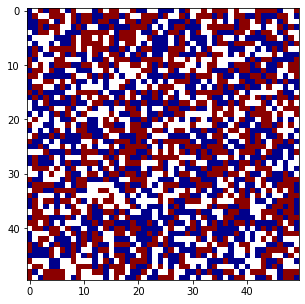

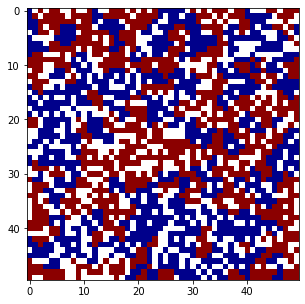

Ségrégation : 0.46416477026298775
La ségrégation est passée de 0.13421256727820685 à 0.46416477026298775


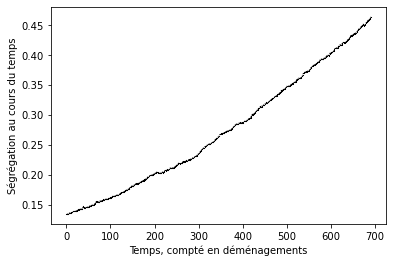

None


In [42]:
# Résumé des paramètres

prop1 = {'libre': 0.3, 'rouge': 1, 'bleu': 1}
# prop2 = {'libre': 0.1, 'rouge': 3, 'vert': 4, 'violet': 3, 'marron': 5}
tol_uniforme = [0.3, 1]
# tol_personnalisee = {'rouge': [0.2, 1], 'bleu': [0.3, 1], 'vert': [0.25, 0.95]}p1 = 1
p1 = 1
# p2 = 3
pond1 = {1: 1, 2: 0.5}
# pond2 = {1: 1, 2: 1, 3: 0.2, 4: 0.1}

# Création de la ville

ville = Ville(portee=p1, proportions=prop1, tolerances=tol_uniforme, ponderation=pond1)

# Résolution

ville.resoudre(afficher_init=True, segregation=True, afficher_seg=True)

# Des exemples

On va ici afficher les premiers modèles de base

C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


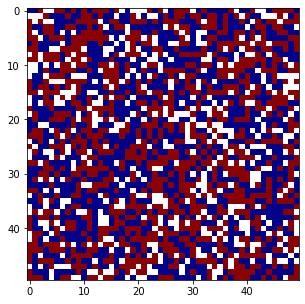

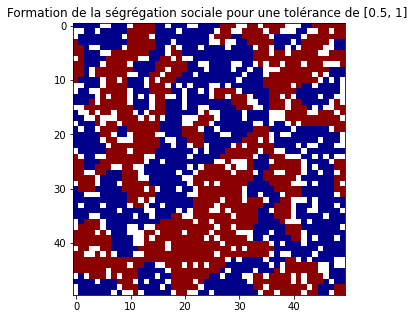

Ségrégation : 0.7017519314035068
La ségrégation est passée de 0.1159014114703788 à 0.7017519314035068


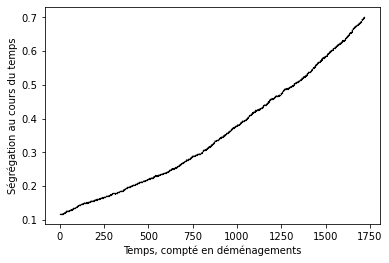

None


In [22]:
## Formation de la ségrégation sociale au cours des déménagements

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tol1 = [0.5, 1]

ville1 = Ville(prop,tol1) #créer l'instance concrète de la classe Ville
ville1.resoudre(afficher_seg=True, 
                segregation=True, 
                afficher_init=True, 
                afficher_resultat=True, 
                titre="Formation de la ségrégation sociale pour une tolérance de [0.5, 1] ")
#appliquer la méthode résoudre à l'instance ville1


C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


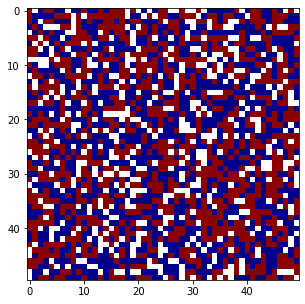

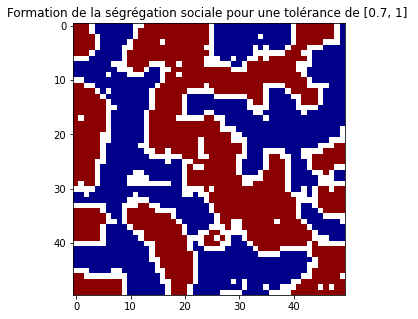

Ségrégation : 0.9606866471373353
La ségrégation est passée de 0.11592739053601064 à 0.9606866471373353


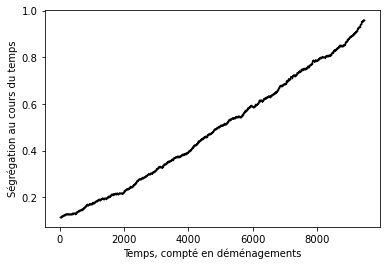

None


In [24]:
## Formation de la ségrégation sociale de manière encore plus nette

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tol2 = [0.7, 1]

ville2 = Ville(prop,tol2) #créer l'instance concrète de la classe Ville
ville2.resoudre(afficher_seg=True, 
                segregation=True, 
                afficher_init=True, 
                afficher_resultat=True, 
                titre="Formation de la ségrégation sociale pour une tolérance de [0.7, 1]")
#appliquer la méthode résoudre à l'instance ville1

C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


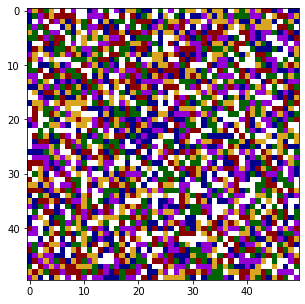

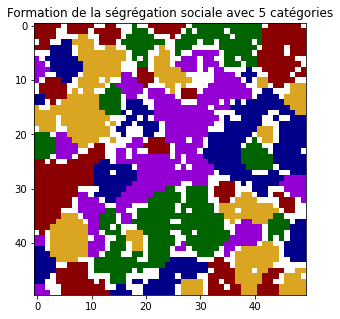

Ségrégation : 0.7330251466646293
La ségrégation est passée de 0.17554533435112052 à 0.7330251466646293


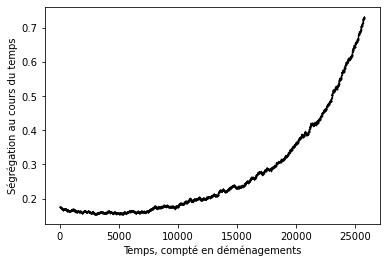

None


In [25]:
## Pour une très belle carte : plein de catégories (5 !)

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1, 'vert': 1, 'jaune': 1, 'violet': 1}
tol = [0.5, 1]

ville = Ville(prop,tol)
ville.resoudre(afficher_seg=True, 
               segregation=True, 
               afficher_init=True, 
               afficher_resultat=True, 
               titre="Formation de la ségrégation sociale avec 5 catégories")


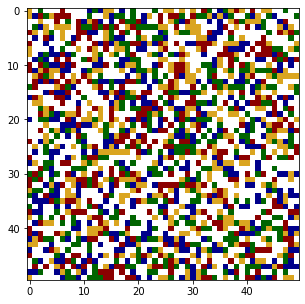

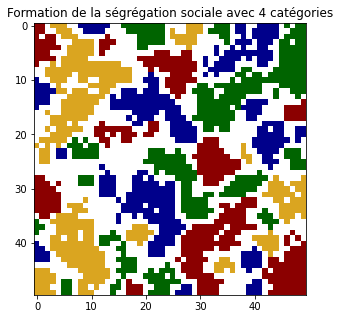

Ségrégation : 0.9416953171910095
La ségrégation est passée de 0.1263702109585565 à 0.9416953171910095


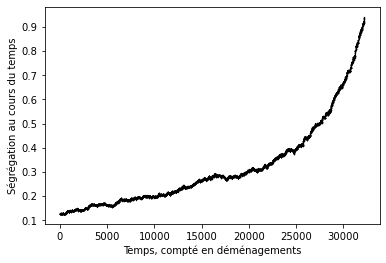

None


In [58]:
## Pour une très belle carte avec une ségrégation très nette : plein de catégories (4 !)

prop = {'libre': 0.4, 'rouge': 1, 'bleu': 1, 'vert': 1, 'jaune': 1}
tol = [0.6, 1]

ville = Ville(prop,tol)
ville.resoudre(afficher_seg=True, 
               segregation=True, 
               afficher_init=True, 
               afficher_resultat=True, 
               titre="Formation de la ségrégation sociale avec 4 catégories")

C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


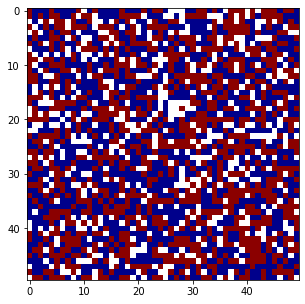

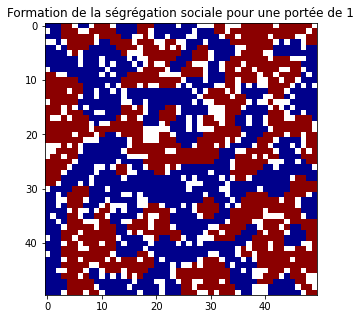

Ségrégation : 0.6570160440760549
La ségrégation est passée de 0.10999812848483281 à 0.6570160440760549


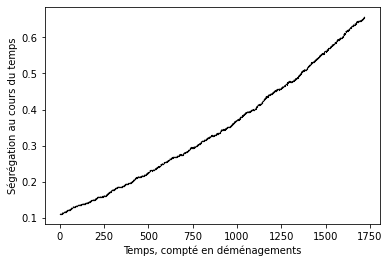

None


C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\nahta\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


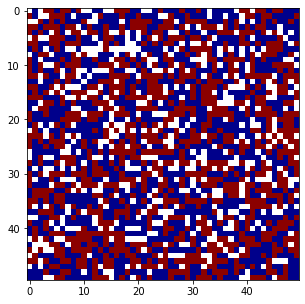

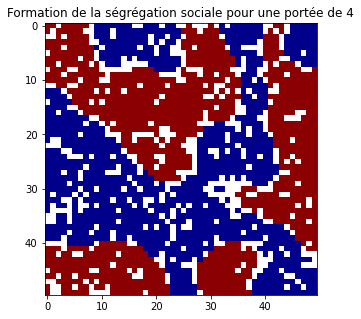

Ségrégation : 0.49024437469045157
La ségrégation est passée de 0.013231003554587617 à 0.49024437469045157


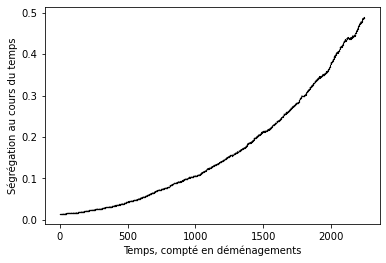

None


In [27]:
## Etendre la portée à laquelle les voisins sont pris en compte

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tol3 =  [0.5, 1]
portee3 = 1 

ville3 = Ville(prop,tol3,portee3)
ville3.resoudre(afficher_seg=True, segregation=True, afficher_init=True, afficher_resultat=True,titre="Formation de la ségrégation sociale pour une portée de 1")

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tol4 =  [0.5, 1]
portee4 = 4

ville4 = Ville(prop,tol4,portee4)
ville4.resoudre(afficher_seg=True, segregation=True, afficher_init=True, afficher_resultat=True,titre="Formation de la ségrégation sociale pour une portée de 4")


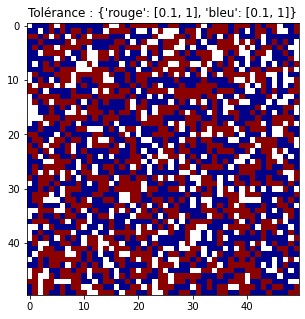

Ségrégation : 0.1183336740588472



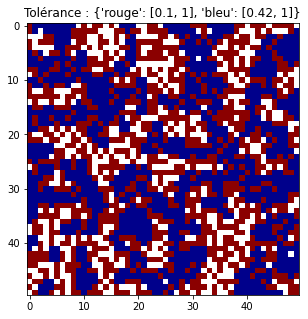

Ségrégation : 0.2861247834610764



In [38]:
## En personalisant les préférences par catégorie

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tol_tous = [0.1, 1]
tol1 = {'rouge': [0.1, 1], 'bleu': [0.1, 1]}
tol4 = {'rouge': [0.1, 1], 'bleu': [0.42, 1]}

ville1 = Ville(prop, tol1)
ville1.resoudre(titre=f"Tolérance : {ville1.tolerances}")
print("")

ville4 = Ville(prop, tol4)
ville4.resoudre(titre=f"Tolérance : {ville4.tolerances}")
print("")

# Nos résultats
Comment le niveau de tolérance impacte la ségrégation ? Comment le fait de prendre en compte des voisins de plus en plus loin (tout un quartier !) impacte le niveau de ségrégation ? Si l'on ajoute plusieurs catégories cela change-t-il beaucoup nos résultats ? 
Ici, on cherche à repérer l'impact de chaque paramètre sur la tolérance. Tous les tests sont donc faits "toutes choses égales par ailleurs" ie en gardant les autres variables fixes.

## 1.1. Faire varier la tolérance : $t_{min}$ uniquement

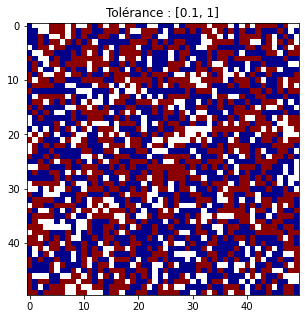

Ségrégation : 0.1252241220213861
Ségrégation & écart-type moyens sur 10 simulations : 
(0.13112197016187355, 0.007426080281409887)



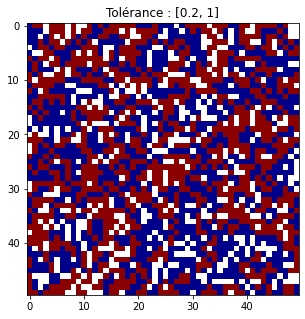

Ségrégation : 0.19362780694371173
Ségrégation & écart-type moyens sur 10 simulations : 
(0.19189054043883513, 0.021740314711071306)



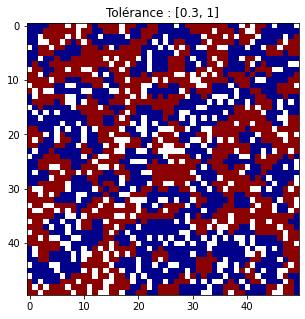

Ségrégation : 0.389191178109874
Ségrégation & écart-type moyens sur 10 simulations : 
(0.41595730638509726, 0.01713578125980254)



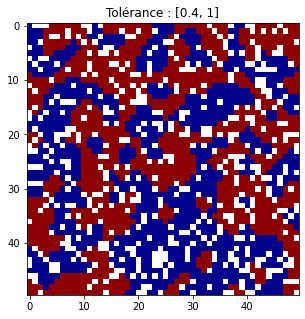

Ségrégation : 0.544530078179281
Ségrégation & écart-type moyens sur 10 simulations : 
(0.5551790022636831, 0.025504755629407107)



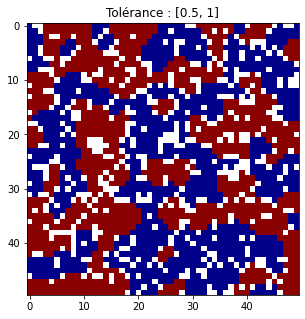

Ségrégation : 0.6741233456845248
Ségrégation & écart-type moyens sur 10 simulations : 
(0.6844887249352112, 0.02285884768236434)



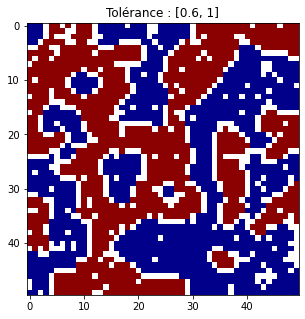

Ségrégation : 0.8804610587418495
Ségrégation & écart-type moyens sur 10 simulations : 
(0.8807580571021069, 0.009569850092251227)



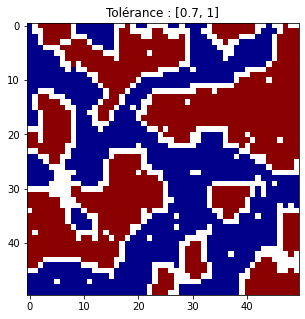

Ségrégation : 0.9607246627351418
Ségrégation & écart-type moyens sur 10 simulations : 
(0.9682325201953791, 0.00637814666198284)



In [34]:
prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tols = [[0.1, 1],
        [0.2, 1],
        [0.3, 1],
        [0.4, 1],
        [0.5, 1],
        [0.6, 1],
        [0.7, 1]]

villes = []
for k in range(len(tols)):
    np.random.seed(0)
    villes.append(Ville(prop, tols[k]))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Tolérance : {ville.tolerances}")
    print(f"Ségrégation & écart-type moyens sur 10 simulations : \n{segregation_moyenne(prop, ville.tolerances)}")
    print("")

## 1.2. Faire varier la tolérance : $t_{max}$

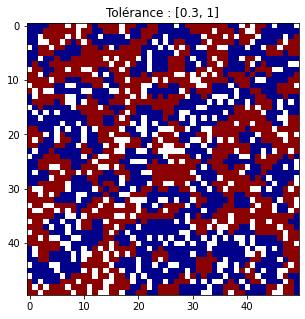

Ségrégation : 0.389191178109874
Ségrégation & écart-type moyens sur 10 simulations : 
(0.41595730638509726, 0.01713578125980254)



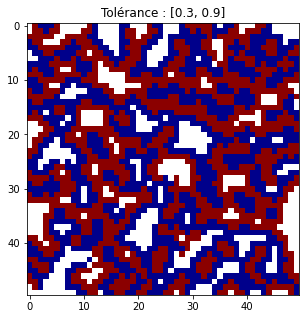

Ségrégation : 0.14587524442003486
Ségrégation & écart-type moyens sur 10 simulations : 
(0.14932230864570012, 0.004301703642458503)



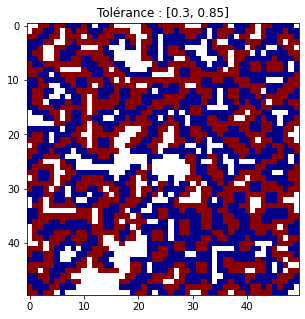

Ségrégation : 0.10372695890893024
Ségrégation & écart-type moyens sur 10 simulations : 
(0.10938997539714368, 0.004490751294429287)



In [56]:
## Faire varier le paramètre tolérance (max surtout) à portée, nombre de catégorie et proportions fixes

prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1}
tols = [[0.3, 1],
        [0.3, 0.9],
        [0.3, 0.85]]

villes = []
for k in range(len(tols)):
    np.random.seed(0)
    villes.append(Ville(prop, tols[k], portee=1))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Tolérance : {ville.tolerances}")
    print(f"Ségrégation & écart-type moyens sur 10 simulations : \n{segregation_moyenne(prop, ville.tolerances)}")
    print("")

## 1.3. Personnaliser les tolérances par catégorie : $t_{min}$

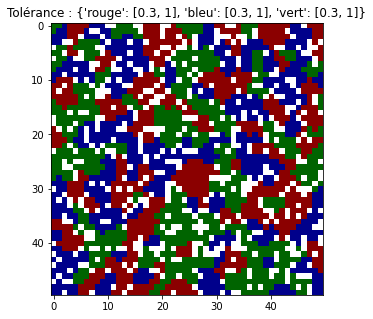

Ségrégation : 0.3892130977733602
Ségrégation & écart-type moyens sur 10 simulations : 
(0.3726448508693106, 0.014849272124131443)



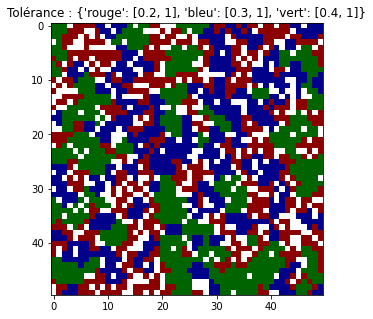

Ségrégation : 0.3293175569441068
Ségrégation & écart-type moyens sur 10 simulations : 
(0.35115748320777873, 0.02258584912564945)



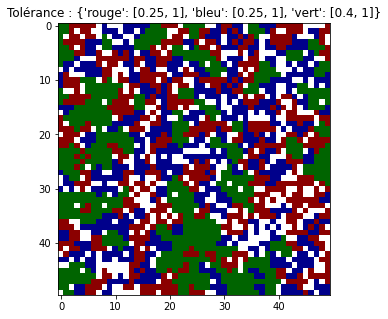

Ségrégation : 0.26964564966165105
Ségrégation & écart-type moyens sur 10 simulations : 
(0.2766188229266448, 0.012273093045504887)



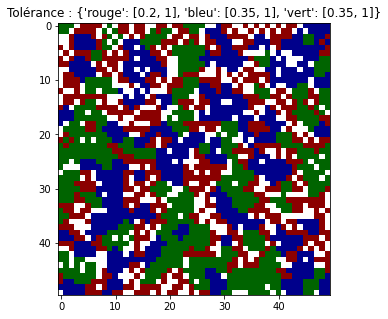

Ségrégation : 0.33501610119509706
Ségrégation & écart-type moyens sur 10 simulations : 
(0.3439822011675714, 0.009622544207009419)



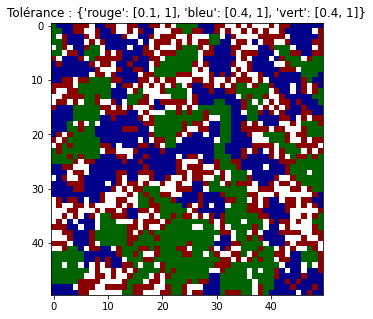

Ségrégation : 0.30807304207829234
Ségrégation & écart-type moyens sur 10 simulations : 
(0.29580340062610366, 0.009595525332305628)



In [57]:
prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1, 'vert': 1}
tols = [{'rouge': [0.3, 1], 'bleu': [0.3, 1], 'vert': [0.3, 1]},
        {'rouge': [0.2, 1], 'bleu': [0.3, 1], 'vert': [0.4, 1]},
        {'rouge': [0.25, 1], 'bleu': [0.25, 1], 'vert': [0.4, 1]},
        {'rouge': [0.2, 1], 'bleu': [0.35, 1], 'vert': [0.35, 1]},
        {'rouge': [0.1, 1], 'bleu': [0.4, 1], 'vert': [0.4, 1]}]
        

villes = []
for k in range(len(tols)):
    np.random.seed(0)
    villes.append(Ville(prop, tols[k]))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Tolérance : {ville.tolerances}")
    print(f"Ségrégation & écart-type moyens sur 10 simulations : \n{segregation_moyenne(prop, ville.tolerances)}")
    print("")


## 1.4. Faire varier la tolérance : $t_{min}$, pour **4 catégories**

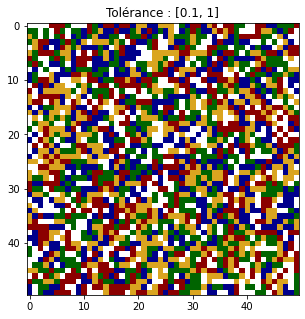

Ségrégation : 0.08857817487960629
Ségrégation & écart-type moyens sur 5 simulations : 
(0.08805814433424981, 0.004111771306032483)



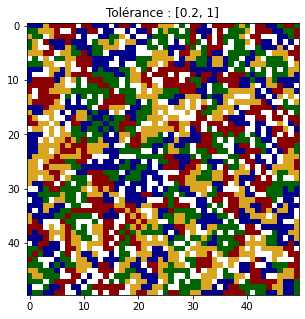

Ségrégation : 0.13852937942634636
Ségrégation & écart-type moyens sur 5 simulations : 
(0.15229097175917478, 0.01593414042657314)



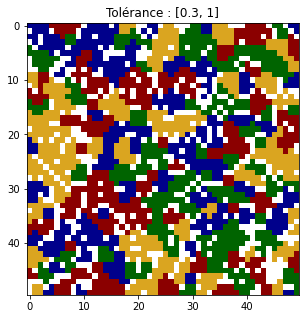

Ségrégation : 0.3942117042646074
Ségrégation & écart-type moyens sur 5 simulations : 
(0.37140712255443187, 0.02249772048697669)



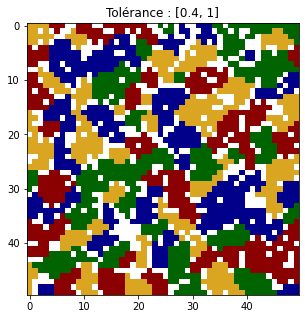

Ségrégation : 0.5281474553398984
Ségrégation & écart-type moyens sur 5 simulations : 
(0.5235964706731819, 0.02904835248818727)



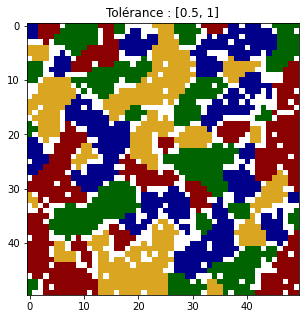

Ségrégation : 0.703008800086292
Ségrégation & écart-type moyens sur 5 simulations : 
(0.6861568301984098, 0.017403319049843775)



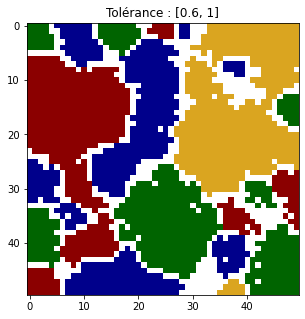

Ségrégation : 0.9529486255363775
Ségrégation & écart-type moyens sur 5 simulations : 
(0.957253406871877, 0.004950103081301809)



In [55]:
prop = {'libre': 0.2, 'rouge': 1, 'bleu': 1, 'vert': 1, 'jaune': 1}
tols = [[0.1, 1],
        [0.2, 1],
        [0.3, 1],
        [0.4, 1],
        [0.5, 1],
        [0.6, 1]]

villes = []
for k in range(len(tols)):
    np.random.seed(0)
    villes.append(Ville(prop, tols[k]))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Tolérance : {ville.tolerances}")
    print(f"Ségrégation & écart-type moyens sur 5 simulations : \n{segregation_moyenne(prop, ville.tolerances, n=5)}")
    print("")

## 2.1. Changer les proportions, à 2

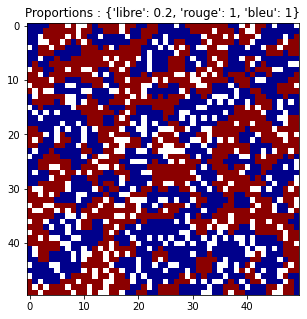

Ségrégation : 0.389191178109874
Ségrégation & écart-type moyens sur 10 simulations : 
(0.41595730638509726, 0.01713578125980254)



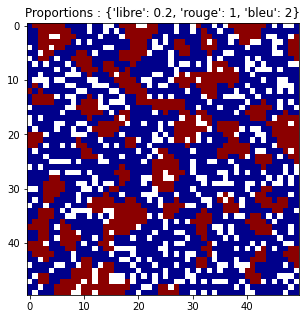

Ségrégation : 0.508481409162026
Ségrégation & écart-type moyens sur 10 simulations : 
(0.5010928591164235, 0.016394293598044247)



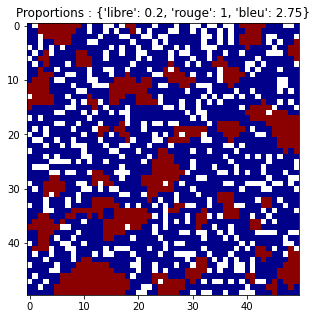

Ségrégation : 0.6087488229213612
Ségrégation & écart-type moyens sur 10 simulations : 
(0.5777356146559451, 0.02063666984294598)



In [45]:
props = [{'libre': 0.2, 'rouge': 1, 'bleu': 1},
         {'libre': 0.2, 'rouge': 1, 'bleu': 2},
         {'libre': 0.2, 'rouge': 1, 'bleu': 2.75}]

tols = [0.3, 1]

villes = []
for k in range(len(props)):
    np.random.seed(0)
    villes.append(Ville(props[k], tols))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Proportions : {ville.proportions}")
    print(f"Ségrégation & écart-type moyens sur 10 simulations : \n{segregation_moyenne(proportions = ville.proportions, tolerances =tols)}")
    print("")

## 2.2. Changer les proportions, à 3

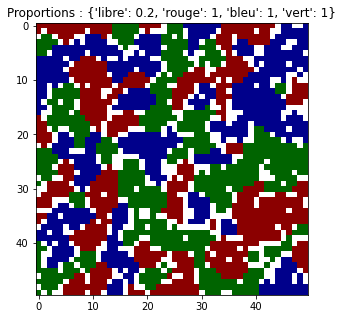

Ségrégation : 0.6748733512463787
Ségrégation & écart-type moyens sur 10 simulations : 
(0.6917351635173333, 0.01678240256971235)



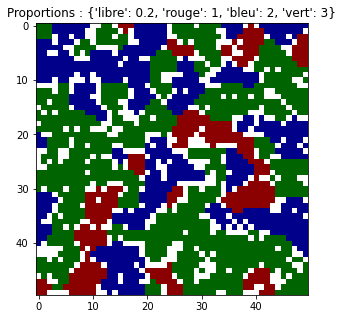

Ségrégation : 0.7253805090673914
Ségrégation & écart-type moyens sur 10 simulations : 
(0.6750269912756369, 0.012898447919378388)



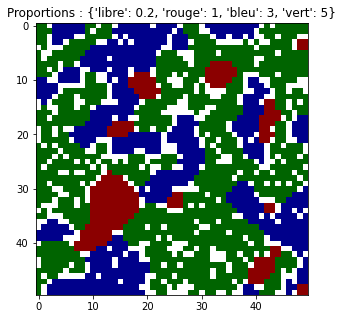

Ségrégation : 0.761087419290331
Ségrégation & écart-type moyens sur 10 simulations : 
(0.6856214495711963, 0.017746956365415387)



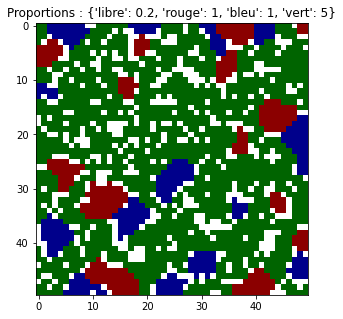

Ségrégation : 0.7695021294600648
Ségrégation & écart-type moyens sur 10 simulations : 
(0.6768552161618119, 0.02053511645202038)



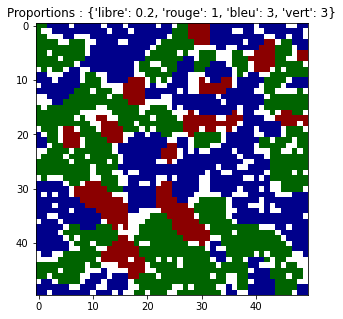

Ségrégation : 0.7270115132635517
Ségrégation & écart-type moyens sur 10 simulations : 
(0.6901278590723967, 0.014486565487948579)



In [47]:
props = [{'libre': 0.2, 'rouge': 1, 'bleu': 1, 'vert': 1},
         {'libre': 0.2, 'rouge': 1, 'bleu': 2, 'vert': 3},
         {'libre': 0.2, 'rouge': 1, 'bleu': 3, 'vert': 5},
         {'libre': 0.2, 'rouge': 1, 'bleu': 1, 'vert': 5},
         {'libre': 0.2, 'rouge': 1, 'bleu': 3, 'vert': 3}]

tols = [0.5, 1]

villes = []
for k in range(len(props)):
    np.random.seed(0)
    villes.append(Ville(props[k], tols))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Proportions : {ville.proportions}")
    print(f"Ségrégation & écart-type moyens sur 10 simulations : \n{segregation_moyenne(prop, ville.tolerances)}")
    print("")

## 3. Etendre la portée

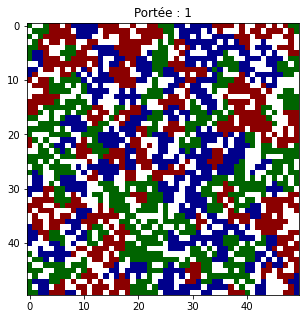

Ségrégation : 0.42720726958042066
Ségrégation & écart-type moyens sur 5 simulations : 
(0.38881132060900897, 0.011779658214161114)



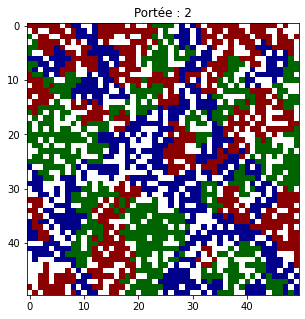

Ségrégation : 0.2687599177139943
Ségrégation & écart-type moyens sur 5 simulations : 
(0.2288812258408611, 0.026830386515647103)



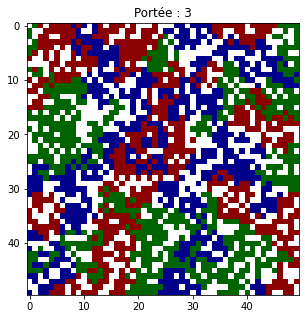

Ségrégation : 0.14060949243608478
Ségrégation & écart-type moyens sur 5 simulations : 
(0.18477751110901927, 0.01818304180788774)



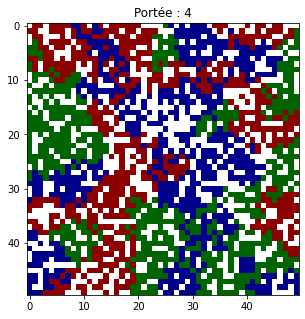

Ségrégation : 0.1244599263563414
Ségrégation & écart-type moyens sur 5 simulations : 
(0.15085181690859262, 0.009782819158558968)



In [33]:
prop = {'libre': 0.3, 'rouge': 1, 'bleu': 1, 'vert': 1}

tol = [0.3, 1]

portees = [1, 2, 3, 4]

# par défaut, ponderation={1: 1, 2: 0.5, 3: 0.2, 4: 0.1}

villes = []
for k in range(len(portees)):
    np.random.seed(0)
    villes.append(Ville(prop, tol, portees[k]))

for ville in villes:
    np.random.seed(0)
    ville.resoudre(titre=f"Portée : {ville.portee}")
    print(f"Ségrégation & écart-type moyens sur 5 simulations : \n{segregation_moyenne(prop, ville.tolerances, portee=ville.portee, n=5)}")
    print("")